In [11]:
import numpy as np
from hmcmc_neurips import langevin, get_posterior
from scipy.stats import norm
from plot_BSN_neurips import plot_bsn
from marginalization_network import BSN_marg

## Fig. 2: A sampling based model for optimal decision making

Code to reproduce the proof-of-concept figure in "A sampling based model for optimal decision making"

### Initialize network parameters and kernels 

For a full derivation of the network, see Rullán and Pillow, 2020. 

In [12]:
nd = 20#number of kernel values
m = 1 #range
centers = np.linspace(-m,m, nd) #centers of kernels
std = .06 #std of kernels
x = np.linspace(-m,m,100) #for plotting

#build kernels over x range
kvals = []
for i in range(centers.shape[0]):
    temp_pdf = norm.pdf(x,centers[i], std) #gaussian kernels
    if i > 0:
        kvals = np.concatenate((kvals,temp_pdf[:,np.newaxis]), axis = 1)
    else:
        kvals = temp_pdf[:,np.newaxis]
        
beta = np.mean(np.mean(kvals,0))*nd #normalization factor
alpha = 800 #decay of c values
dt = 1/10 #time bin size

nsamp = 2000 #samples to input to simulation
N = 160 #number of neurons in network

#randomly generated decoding weights
ww = np.random.randn(nd,N)
ww = 0.1*(ww/np.linalg.norm(ww,1)) #rescale

T = (np.sum(ww.T**2, 1))*0.5

params = {
    'N': N,
    'T': T,
    'ww': ww,
    'fmax': 1,
    'gamma': 1e6,
    'fmin': 0,
    'taud': 20,
    'kernels': kvals,
    'm': m, 
    'beta': beta,
    'alpha': alpha}

### Generate stimulus

For simplicity, here the input to the network are Langevin samples from the appropriate posterior and we omit the code to implement the first inference circuit. Both processes are equivalent as the distributed sampling circuit implements Langevin sampling.

#### Calculate posterior distribution

In [13]:
sigma_prior = np.array([[.8, -.3], [-.3,  .2]]) #prior variance
mu_prior = np.array([0, 0]) #prior mean

sigma_noise = np.array([[.1, 0], [0, .1]]) #observation noise
obs = np.array([-0.2, .1]) #stimulus location

mu_post, sigma_post = get_posterior(obs, mu_prior, sigma_prior, sigma_noise) #get posterior

#### Generate samples from the prior and posterior

In [14]:
epsilon = .1 #sampling speed
params_pr = { #prior distribution
    'mu': np.asarray([mu_prior[0]]),
    'cov_inv': 1/np.array([sigma_prior[0,0]**2])}

params_post = { #posterior distribution
    'mu': np.asarray(mu_post[0]),
    'cov_inv': 1/np.array(sigma_post[0,0])}

stim_pr = langevin(params_pr, epsilon, 1, 2*nsamp).T
stim_post = langevin(params_post, epsilon, 1, 2*nsamp, init = stim_pr[:,-1]).T

stim =  np.hstack((stim_pr[:, nsamp:], stim_post)) #concatenate samples from prior and posterior (ignoring burn-in period)
stim = np.tile(stim, (nd, 1)) 

NT = stim.shape[1] #length of simulation
time = np.asarray([np.arange(0, NT*dt, dt)])  # time vector

### Run network

In [15]:
[oo, rr, ch, cc, vv] = BSN_marg(stim, dt, params)

### Plot network output

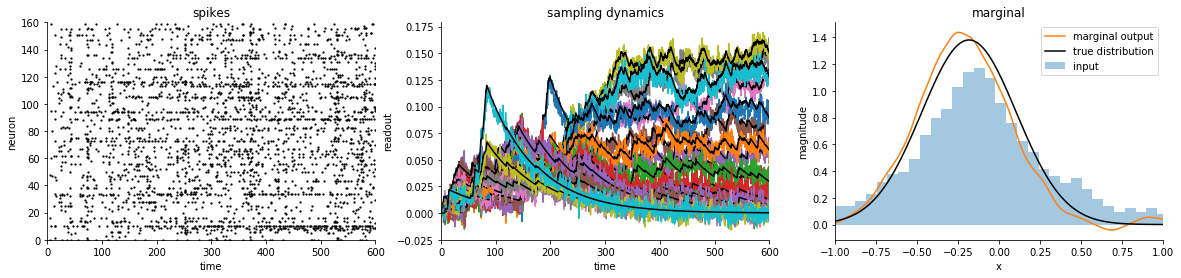

In [16]:
plot_bsn(time, ch, cc, oo, 0, cc.shape[1], dt, N, stim, kvals, m, params = params_post)